In [52]:
import json
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import gensim
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from nltk.tokenize import sent_tokenize, wordpunct_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from tqdm import tqdm

Здесь я решила попробовать проанализировать тексты эпизодов с точки зрения похожести самих эпизодов и персонажей. Персонажей я анализировала с помощью word2vec, а эпизоды с помощью tf-idf. Анализ персонажей был так же добавлен в телеграм бота.

In [136]:
re_character = re.compile(r'(.+?):')
re_text = re.compile(r': (.+)')
re_episode = re.compile(r'(\w+?)\.')
re_del = re.compile(r'\[.+?\]')

In [137]:
def define_character(lines, file):
    character_texts = []
    episode = re_episode.match(file)[1]
    for n, line in enumerate(lines):
        line = re_del.sub('', line)
        if re_character.match(line) and re_text.search(line):
            character = re_character.match(line)[1]
            text = re_text.search(line)[1]
            character_texts.append(
                {'character': character, 
                 'episode': episode, 
                 'line': text}
            )
    return character_texts

In [138]:
characters_table = pd.DataFrame(columns=['character', 'episode', 'line'])
for root, dirs, files in os.walk('../SpongeBob_SquarePants_Transcripts'):
    for file in tqdm(files):
        path = os.path.join(root, file)
        with open(path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        character_texts = define_character(lines, file)
        characters_table = characters_table.append(character_texts, ignore_index=True)

100%|████████████████████████████████████████| 393/393 [00:00<00:00, 710.85it/s]


In [139]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
nltk_to_pos = {'ADV': 'r', 'NOUN': 'n', 'VERB': 'v', 'ADJ': 'a'}

In [140]:
def for_model(line):
    lemmas = []
    new_sent = []
    sentences = sent_tokenize(line)
    for sent in sentences:
        words = [word for word in word_tokenize(sent) if word[-1] not in punctuation]
        for word in words:
            pos = pos_tag([word], tagset='universal')[0][1]
            if pos in ['VERB', 'NOUN', 'ADV', 'ADJ']:
                word = lemmatizer.lemmatize(word.lower(), pos=nltk_to_pos[pos])
            else:
                word = lemmatizer.lemmatize(word.lower())
            lemmas.append(word)
        if lemmas != []:
            new_sent.append(' '.join(lemmas))
        lemmas = []
    return ' '.join(new_sent)

In [85]:
characters_table['lemmatized_lines'] = characters_table['line'].apply(for_model)
all_lines = characters_table.groupby('character')['lemmatized_lines'].agg(list).reset_index()

In [89]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [144]:
for i, name in enumerate(all_lines['character'].unique().tolist()):
    with open(f'lol.txt', 'a') as f:
        f.write('\n'.join(all_lines[all_lines['character'] == name]['lemmatized_lines'][i]))

In [145]:
text = f'lol.txt'
data = gensim.models.word2vec.LineSentence(text)
model_char = gensim.models.Word2Vec(data, vector_size=300, window=5, min_count=2)
model_char.init_sims(replace=True)
model_path = f'lol.bin'
model_char.wv.save_word2vec_format(model_path, binary=True)

2022-03-30 23:51:52,673 : INFO : collecting all words and their counts
2022-03-30 23:51:52,675 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-03-30 23:51:52,745 : INFO : PROGRESS: at sentence #10000, processed 117318 words, keeping 8655 word types
2022-03-30 23:51:52,780 : INFO : PROGRESS: at sentence #20000, processed 222078 words, keeping 11933 word types
2022-03-30 23:51:52,812 : INFO : PROGRESS: at sentence #30000, processed 336147 words, keeping 14293 word types
2022-03-30 23:51:52,844 : INFO : collected 16546 word types from a corpus of 449405 raw words and 39985 sentences
2022-03-30 23:51:52,845 : INFO : Creating a fresh vocabulary
2022-03-30 23:51:52,866 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 7832 unique words (47.33470325154116%% of original 16546, drops 8714)', 'datetime': '2022-03-30T23:51:52.866420', 'gensim': '4.1.2', 'python': '3.9.6 (v3.9.6:db3ff76da1, Jun 28 2021, 11:49:53) \n[Clang 6.0 (clang-600.0.57)]

Я решила визуализировать близость с помощью PCA. Проблемой оказалось то, что про многих персонажей не было упоминаний в тексте, поэтому пришлось использовать try-except. Также, чтобы не захламлять рисунок, я решила оставить только тех персонажей, у которых было более 5 реплик, хотя бы.

In [151]:
names = characters_table['character'].unique().tolist()
vectors = []
new_names = []
for name in names:
    try:
        if (characters_table['character'] == name).sum() > 5:
            a = model_char.wv[name.lower()]
            vectors.append(a)
            new_names.append(name)
    except:
        pass

In [153]:
pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

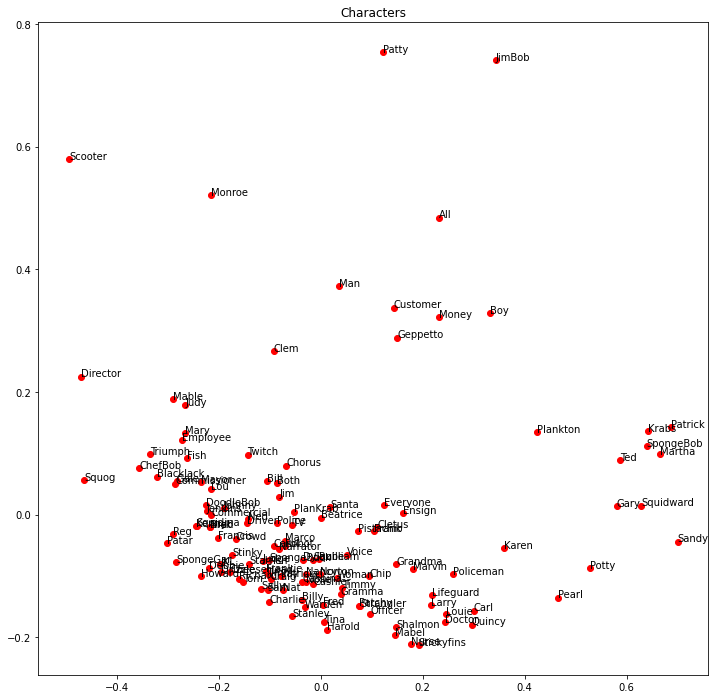

In [154]:
plt.figure(figsize=(12, 12))
plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Characters')

for i, name in enumerate(new_names):
    plt.annotate(name, xy=(coords[i, 0], coords[i, 1]))
#plt.show()
plt.savefig('characters.png', dpi = 100)

Дальше я с помощью tf-idf проанализировала близость эпизодов, но так как их много, а рисунок не бесконечен, я вывела только 70 из них, и не вставляла в бота

In [61]:
texts = []
files = []
for root, dirs, files in os.walk('../SpongeBob_SquarePants_Transcripts'):
    for file in tqdm(files):
        path = os.path.join(root, file)
        with open(path, 'r', encoding='utf-8') as f:
            text = f.read()
            name = file
        texts.append(text)
        names.append(name)

100%|███████████████████████████████████████| 393/393 [00:00<00:00, 5307.07it/s]


In [66]:
lemmas = []
for text in tqdm(texts):
    lemma = for_model(text)
    lemmas.append(lemma)

100%|█████████████████████████████████████████| 393/393 [01:28<00:00,  4.42it/s]


In [71]:
tfidf = TfidfVectorizer(
    analyzer="word",
    stop_words=sw,
    min_df=3,
    ngram_range=(1, 3))
bob_tfidf = tfidf.fit_transform(lemmas)
print(f'Матрица на {bob_tfidf.shape[0]} документов и {bob_tfidf.shape[1]} термов')

Матрица на 393 документов и 35390 термов


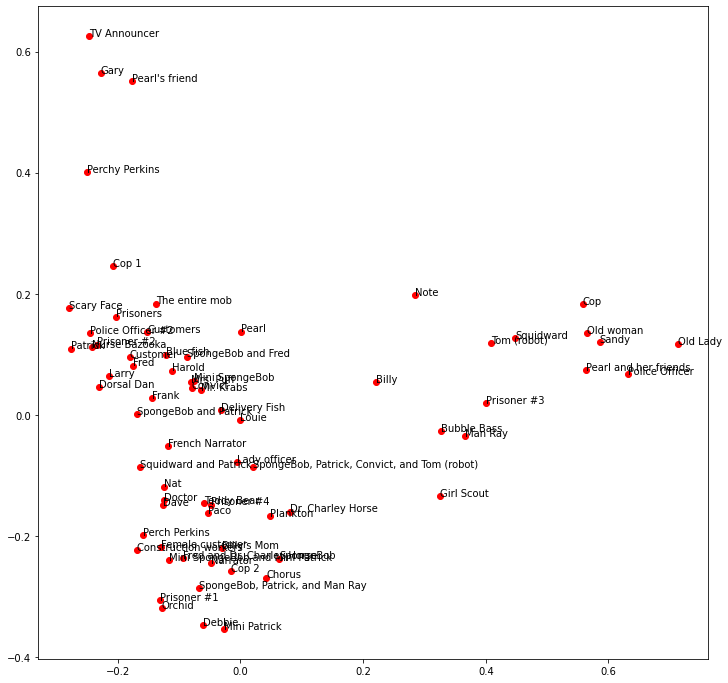

In [135]:
bob_result = bob_tfidf.toarray()
bob_coords = pca.fit_transform(bob_result[:70])
plt.figure(figsize=(12, 12))
plt.scatter(bob_coords[:, 0], bob_coords[:, 1], color='red')
for i, name in enumerate(names[:70]):
    plt.annotate(name, xy=(bob_coords[i, 0], bob_coords[i, 1]))
plt.show()